# MNIST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
#sns.set(style='white', context='notebook', palette='deep')


from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.callbacks import EarlyStopping, ModelCheckpoint# early stopping

batch_size = 128 # in each iteration, we consider 128 training examples at once
num_epochs = 50 # we iterate twelve times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth = 256 # use 32 kernels in both convolutional layers   #changes made here
drop_prob_1 = 0.3 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 128 # there will be 128 neurons in both hidden layers

num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000 # there are 10000 test examples in MNIST

height, width, depth = 28, 28, 1 # MNIST images are 28x28 and greyscale
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

X_train = X_train.reshape(X_train.shape[0], height, width, depth)
X_test = X_test.reshape(X_test.shape[0], height, width, depth)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

inp = Input(shape=(height, width, depth)) # N.B. TensorFlow back-end expects channel dimension last
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(32, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(inp)
conv_2 = Convolution2D(32, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_2)
drop_1 = Dropout(0.25)(pool_1)
conv_3 = Convolution2D(64, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(drop_1)
conv_4 = Convolution2D(64, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(conv_3)
pool_2 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv_4)
drop_2 = Dropout(0.25)(pool_2)
flat = Flatten()(drop_2)
hidden = Dense(256, activation='relu')(flat) # Hidden ReLU layer
drop = Dropout(0.5)(hidden)
out = Dense(num_classes, activation='softmax')(drop) # Output softmax layer

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


checkpointer = ModelCheckpoint('model-mnist.h5', verbose=1, save_best_only=True)
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,checkpointer])
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!



/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/50
 - 9s - loss: 0.3901 - acc: 0.8745 - val_loss: 0.0574 - val_acc: 0.9803

Epoch 00001: val_loss improved from inf to 0.05735, saving model to model-mnist.h5
Epoch 2/50
 - 6s - loss: 0.1291 - acc: 0.9619 - val_loss: 0.0370 - val_acc: 0.9885

Epoch 00002: val_loss improved from 0.05735 to 0.03705, saving model to model-mnist.h5
Epoch 3/50
 - 6s - loss: 0.0906 - acc: 0.9743 - val_loss: 0.0268 - val_acc: 0.9903

Epoch 00003: val_loss improved from 0.03705 to 0.02676, saving model to model-mnist.h5
Epoch 4/50
 - 6s - loss: 0.0777 - acc: 0.9769 - val_loss: 0.0315 - val_acc: 0.9898

Epoch 00004: val_loss did not improve from 0.02676
Epoch 5/50
 - 6s - loss: 0.0660 - acc: 0.9804 - val_loss: 0.0272 - val_acc: 0.9910

Epoch 00005: val_loss did not improve from 0.02676
Epoch 6/50
 - 7s - loss: 0.0617 - acc: 0.9817 - val_loss: 0.0247 - val_acc: 0.9917

Epoch 00006: val_loss improved from 0.02676 to 0.02475, saving model to model-mnist.h5
Epoch 7/50
 - 8s - loss: 0.0561 - acc: 0.9836 - va

[0.009334088244617305, 0.997]

# EMNIST

# NN 1 84.85%

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_db = pd.read_csv("/media/jamil/SSD SUPER FAST/zubayer vai/thesis/tensorflow/exmnist/data/emnist/emnist-balanced-train.csv")
test_db  = pd.read_csv("/media/jamil/SSD SUPER FAST/zubayer vai/thesis/tensorflow/exmnist/data/emnist/emnist-balanced-test.csv")

In [5]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model

num_classes = 47
y_train = train_db.iloc[:,0]
y_train = np_utils.to_categorical(y_train, num_classes)
print ("y_train:", y_train.shape)

x_train = train_db.iloc[:,1:]
x_train = x_train.astype('float32')
x_train /= 255
print ("x_train:",x_train.shape)

inp = Input(shape=(784,))
hidden_1 = Dense(1024, activation='relu')(inp)
dropout_1 = Dropout(0.2)(hidden_1)
out = Dense(num_classes, activation='softmax')(hidden_1) 
model = Model(input=inp, output=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

model.fit(x_train, y_train, # Train the model using the training set...
          batch_size=512, nb_epoch=10,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation

y_test = test_db.iloc[:,0]
y_test = np_utils.to_categorical(y_test, num_classes)
print ("y_test:", y_test.shape)

x_test = test_db.iloc[:,1:]
x_test = x_test.astype('float32')
x_test /= 255
print ("x_test:",x_train.shape)

print(model.evaluate(x_test, y_test, verbose=1)) # Evaluate the trained model on the test set!


('y_train:', (112799, 47))
('x_train:', (112799, 784))
Train on 101519 samples, validate on 11280 samples
Epoch 1/10


/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


101519/101519 [==============================] - 2s 16us/step - loss: 1.2438 - acc: 0.6587 - val_loss: 0.8319 - val_acc: 0.7488
Epoch 2/10
101519/101519 [==============================] - 1s 15us/step - loss: 0.7090 - acc: 0.7872 - val_loss: 0.6368 - val_acc: 0.8005
Epoch 3/10
101519/101519 [==============================] - 1s 15us/step - loss: 0.5594 - acc: 0.8245 - val_loss: 0.5672 - val_acc: 0.8149
Epoch 4/10
101519/101519 [==============================] - 2s 15us/step - loss: 0.4819 - acc: 0.8459 - val_loss: 0.5272 - val_acc: 0.8257
Epoch 5/10
101519/101519 [==============================] - 2s 15us/step - loss: 0.4310 - acc: 0.8591 - val_loss: 0.5100 - val_acc: 0.8308
Epoch 6/10
101519/101519 [==============================] - 2s 15us/step - loss: 0.3951 - acc: 0.8684 - val_loss: 0.4921 - val_acc: 0.8358
Epoch 7/10
101519/101519 [==============================] - 1s 15us/step - loss: 0.3644 - acc: 0.8763 - val_loss: 0.4765 - val_acc: 0.8382
Epoch 8/10
101519/101519 [============

# NN 85.25%

In [9]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = 47
y_train = train_db.iloc[:,0]
y_train = np_utils.to_categorical(y_train, num_classes)
print ("y_train:", y_train.shape)

x_train = train_db.iloc[:,1:]
x_train = x_train.astype('float32')
x_train /= 255
print ("x_train:",x_train.shape)

inp = Input(shape=(784,))
h1 = Dense(1024, activation='relu')(inp)
d1 = Dropout(0.2)(h1)
out = Dense(num_classes, activation='softmax')(d1) 
model = Model(input=inp, output=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
checkpointer = ModelCheckpoint('model-emnist-nn.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)

history=model.fit(x_train, y_train, # Train the model using the training set...
          batch_size=512, nb_epoch=50,
          verbose=1, validation_split=0.1,callbacks=[earlystopper,checkpointer]) # ...holding out 10% of the data for validation

y_test = test_db.iloc[:,0]
y_test = np_utils.to_categorical(y_test, num_classes)
print ("y_test:", y_test.shape)

x_test = test_db.iloc[:,1:]
x_test = x_test.astype('float32')
x_test /= 255
print ("x_test:",x_train.shape)

print(model.evaluate(x_test, y_test, verbose=1)) # Evaluate the trained model on the test set!


('y_train:', (112799, 47))
('x_train:', (112799, 784))


/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 101519 samples, validate on 11280 samples
Epoch 1/50
101519/101519 [==============================] - 2s 17us/step - loss: 1.3052 - acc: 0.6380 - val_loss: 0.8429 - val_acc: 0.7503

Epoch 00001: val_loss improved from inf to 0.84290, saving model to model-emnist-nn.h5
Epoch 2/50
101519/101519 [==============================] - 2s 15us/step - loss: 0.7575 - acc: 0.7726 - val_loss: 0.6503 - val_acc: 0.7988

Epoch 00002: val_loss improved from 0.84290 to 0.65029, saving model to model-emnist-nn.h5
Epoch 3/50
101519/101519 [==============================] - 2s 15us/step - loss: 0.6073 - acc: 0.8120 - val_loss: 0.5734 - val_acc: 0.8152

Epoch 00003: val_loss improved from 0.65029 to 0.57336, saving model to model-emnist-nn.h5
Epoch 4/50
101519/101519 [==============================] - 2s 15us/step - loss: 0.5304 - acc: 0.8311 - val_loss: 0.5255 - val_acc: 0.8277

Epoch 00004: val_loss improved from 0.57336 to 0.52547, saving model to model-emnist-nn.h5
Epoch 5/50
101519/101519 [===

# NN 86.68% accuracy (BEST)

In [20]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = 47
y_train = train_db.iloc[:,0]
y_train = np_utils.to_categorical(y_train, num_classes)
print ("y_train:", y_train.shape)

x_train = train_db.iloc[:,1:]
x_train = x_train.astype('float32')
x_train /= 255
print ("x_train:",x_train.shape)

inp = Input(shape=(784,))
h1 = Dense(1024, activation='relu')(inp)
d1 = Dropout(0.4)(h1)
h2 = Dense(1024, activation='relu')(d1)
d2 = Dropout(0.4)(h2)
out = Dense(num_classes, activation='softmax')(d2) 
model = Model(input=inp, output=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
checkpointer = ModelCheckpoint('model-emnist-nn.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)

history=model.fit(x_train, y_train, # Train the model using the training set...
          batch_size=512, nb_epoch=50,
          verbose=1, validation_split=0.1,callbacks=[earlystopper,checkpointer]) # ...holding out 10% of the data for validation

y_test = test_db.iloc[:,0]
y_test = np_utils.to_categorical(y_test, num_classes)
print ("y_test:", y_test.shape)

x_test = test_db.iloc[:,1:]
x_test = x_test.astype('float32')
x_test /= 255
print ("x_test:",x_train.shape)

print(model.evaluate(x_test, y_test, verbose=1)) # Evaluate the trained model on the test set!

('y_train:', (112799, 47))
('x_train:', (112799, 784))


/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/jamil/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 101519 samples, validate on 11280 samples
Epoch 1/50
101519/101519 [==============================] - 2s 23us/step - loss: 1.2736 - acc: 0.6333 - val_loss: 0.6852 - val_acc: 0.7802

Epoch 00001: val_loss improved from inf to 0.68520, saving model to model-emnist-nn.h5
Epoch 2/50
101519/101519 [==============================] - 2s 18us/step - loss: 0.7076 - acc: 0.7743 - val_loss: 0.5484 - val_acc: 0.8180

Epoch 00002: val_loss improved from 0.68520 to 0.54845, saving model to model-emnist-nn.h5
Epoch 3/50
101519/101519 [==============================] - 2s 18us/step - loss: 0.5907 - acc: 0.8040 - val_loss: 0.4915 - val_acc: 0.8325

Epoch 00003: val_loss improved from 0.54845 to 0.49148, saving model to model-emnist-nn.h5
Epoch 4/50
101519/101519 [==============================] - 2s 18us/step - loss: 0.5298 - acc: 0.8217 - val_loss: 0.4591 - val_acc: 0.8424

Epoch 00004: val_loss improved from 0.49148 to 0.45913, saving model to model-emnist-nn.h5
Epoch 5/50
101519/101519 [===

# EMNIST CNN (BALANCED)- 47 class

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
#sns.set(style='white', context='notebook', palette='deep')
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.callbacks import EarlyStopping, ModelCheckpoint# early stopping

In [22]:
%matplotlib inline
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam
from keras.layers.advanced_activations import LeakyReLU
# used to save and load training histories
import pickle
from collections import defaultdict

import resource, sys

# we would reach recursion limit when saving training history otherwise
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(2**29 - 1)
from scipy import io as spio
emnist = spio.loadmat("/media/jamil/SSD SUPER FAST/zubayer vai/thesis/tensorflow/exmnist/matlab/emnist-balanced.mat")

In [23]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [24]:
print x_train.shape
print y_train.shape
# normalize
x_train /= 255
x_test /= 255

(112800, 784)
(112800, 1)


In [25]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(112800, 1, 28, 28)
(112800, 1)
(18800, 1, 28, 28)
(18800, 1)


In [27]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 47)
y_test = keras.utils.to_categorical(y_test, 47)

print y_train.shape
print y_test.shape

(112800, 47)
(18800, 47)


32


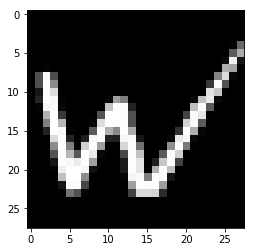

In [28]:
# which sample to look at
samplenum = 3333
import matplotlib.pyplot as plt

img = x_train[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')
# show label for sample image
print train_labels[samplenum][0]

# Reshape test labels

In [29]:
test_labels.shape

(18800, 1)

In [30]:
test_labels = test_labels.reshape(18800)

In [31]:
test_labels.shape

(18800,)

# DEFINE MODEL (90.59%)

In [32]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [33]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

## Data augmentation

In [136]:
batch_size = 512
gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format='channels_first')  # randomly flip images

batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))
img = x_train[3333]
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

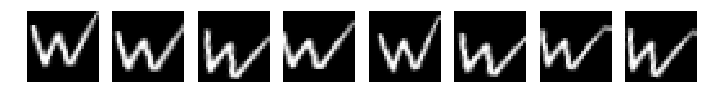

In [137]:
# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# MODEL

In [89]:
batch_size=512
inp = Input(shape=(1, 28, 28)) # N.B. TensorFlow back-end expects channel dimension last
conv_1 = Convolution2D(64, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(inp)
conv_2 = Convolution2D(64, (5,5), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(conv_2)
drop_1 = Dropout(0.25)(pool_1)
conv_3 = Convolution2D(128, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(drop_1)
conv_4 = Convolution2D(128, (3,3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', data_format='channels_first')(conv_3)
pool_2 = MaxPooling2D(pool_size=(2,2),strides=(2,2), data_format='channels_first')(conv_4)
drop_2 = Dropout(0.25)(pool_2)
flat = Flatten()(drop_2)
hidden = Dense(1024, activation='relu')(flat) # Hidden ReLU layer
drop = Dropout(0.5)(hidden)
out = Dense(47, activation='softmax')(drop) # Output softmax layer

model = Model(inputs=inp, outputs=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
model.summary()
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)



datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format='channels_first')  # randomly flip images


datagen.fit(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 28, 28)        1664      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 28, 28)        102464    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 14, 14)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 14, 14)       147584    
__________

In [90]:
checkpointer = ModelCheckpoint('model-emnist-cnn.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test, y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[earlystopper,learning_rate_reduction,checkpointer])


Epoch 1/50
 - 14s - loss: 1.1086 - acc: 0.6678 - val_loss: 0.3872 - val_acc: 0.8653

Epoch 00001: val_loss improved from inf to 0.38719, saving model to model-emnist-cnn.h5
Epoch 2/50
 - 13s - loss: 0.5019 - acc: 0.8268 - val_loss: 0.3493 - val_acc: 0.8754

Epoch 00002: val_loss improved from 0.38719 to 0.34931, saving model to model-emnist-cnn.h5
Epoch 3/50
 - 13s - loss: 0.4341 - acc: 0.8471 - val_loss: 0.3206 - val_acc: 0.8859

Epoch 00003: val_loss improved from 0.34931 to 0.32064, saving model to model-emnist-cnn.h5
Epoch 4/50
 - 13s - loss: 0.3962 - acc: 0.8592 - val_loss: 0.3137 - val_acc: 0.8874

Epoch 00004: val_loss improved from 0.32064 to 0.31370, saving model to model-emnist-cnn.h5
Epoch 5/50
 - 14s - loss: 0.3750 - acc: 0.8654 - val_loss: 0.3037 - val_acc: 0.8891

Epoch 00005: val_loss improved from 0.31370 to 0.30373, saving model to model-emnist-cnn.h5
Epoch 6/50
 - 14s - loss: 0.3572 - acc: 0.8698 - val_loss: 0.3047 - val_acc: 0.8910

Epoch 00006: val_loss did not impr

In [93]:
model.evaluate(x_test, y_test, verbose=1) # Evaluate the trained model on the test set!

18800/18800 [==============================] - 2s 112us/step


[0.2695174662198158, 0.9059574468085106]

['acc', 'loss', 'val_acc', 'val_loss', 'lr']


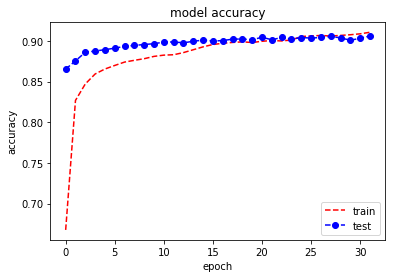

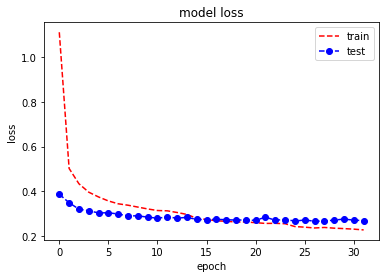

In [94]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'],'r--')
plt.plot(history.history['val_acc'], 'bo--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],'r--')
plt.plot(history.history['val_loss'],'bo--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## visualize

In [95]:
# predict classes
preds_prob = model.predict(x_test, batch_size=512)

In [96]:
preds_prob.shape
preds = preds_prob.argmax(axis=-1)

In [97]:
print preds.shape

(18800,)


In [98]:
test_labels.shape

(18800,)

In [99]:
correct = np.where(preds==test_labels)[0]
incorrect = np.where(preds!=test_labels)[0]

In [100]:
print correct.shape
print incorrect.shape

(17032,)
(1768,)


In [101]:
# number of images to view
n_view = incorrect.shape[0]

In [102]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [103]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [104]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [105]:
imgs.shape

(1768, 1, 28, 28)

In [167]:
def lvling47class(x):
    if x==0:
        y= '0'
    elif x==1:
        y= '1'
    elif x==2:
        y= '2'
    elif x==3:
        y= '3'
    elif x==4:
        y= '4'
    elif x==5:
        y= '5'
    elif x==6:
        y= '6'
    elif x==7:
        y= '7'
    elif x==8:
        y= '8'
    elif x==9:
        y= '9'
    elif x==10:
        y= 'A'
    elif x==11:
        y= 'B'
    elif x==12:
        y= 'C'
    elif x==13:
        y= 'D'
    elif x==14:
        y= 'E'
    elif x==15:
        y= 'F'
    elif x==16:
        y= 'G'
    elif x==17:
        y= 'H'
    elif x==18:
        y= 'I'
    elif x==19:
        y= 'J'
    elif x==20:
        y= 'K'
    elif x==21:
        y= 'L'
    elif x==22:
        y= 'M'
    elif x==23:
        y= 'N'
    elif x==24:
        y= 'O'
    elif x==25:
        y= 'P'
    elif x==26:
        y= 'Q'
    elif x==27:
        y= 'R'
    elif x==28:
        y= 'S'
    elif x==29:
        y= 'T'
    elif x==30:
        y= 'U'
    elif x==31:
        y= 'V'
    elif x==32:
        y= 'W'
    elif x==33:
        y= 'X'
    elif x==34:
        y= 'Y'
    elif x==35:
        y= 'Z'
    elif x==36:
        y= 'a'
    elif x==37:
        y= 'b'
    elif x==38:
        y= 'c'
    elif x==39:
        y= 'd'
    elif x==40:
        y= 'e'
    elif x==41:
        y= 'g'
    elif x==42:
        y= 'h'
    elif x==43:
        y= 'n'
    elif x==44:
        y= 'q'
    elif x==45:
        y= 'r'
    elif x==46:
        y= 't'
    else :
        y= 'no level'
    
    return y

#testing leveling
result = lvling47class(preds_correct[0])
print result

T


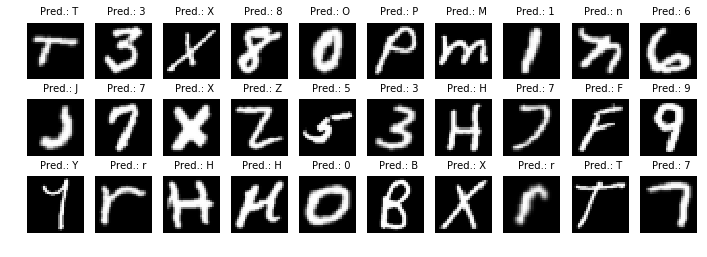

In [169]:
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    #sp.set_title(preds_correct[i])
    sp.text(0.9, 1.2, "Pred.: {}"
                 .format(lvling47class(preds_correct[i])),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

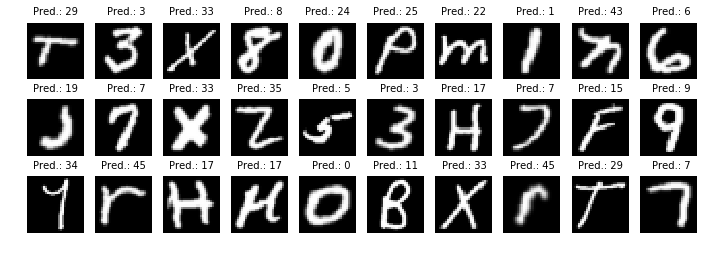

In [158]:
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    #sp.set_title(preds_correct[i])
    sp.text(0.9, 1.2, "Pred.: {}"
                 .format(preds_correct[i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [107]:

# ground truth labels
test_labels[idx]

array([29,  3, 33,  8, 24, 25, 22,  1, 43,  6, 19,  7, 33, 35,  5,  3, 17,
        7, 15,  9, 34, 45, 17, 17,  0, 11, 33, 45, 29,  7, 15, 16, 42, 30,
       14, 31, 10, 19, 15, 40, 22, 27, 23, 14, 25, 28, 14, 32, 12, 38, 43,
       15, 45,  5, 12, 13,  6, 16, 15,  8, 17, 21, 12, 42, 41, 33, 45, 43,
       33, 11,  6, 19, 37, 22, 29, 11, 46, 23, 28, 23, 14, 33, 14, 43, 26,
       36, 14, 31, 10, 17,  8, 30,  8,  9, 44, 14, 30, 43, 15, 29, 46, 31,
        5,  0, 45, 45, 10,  2, 27, 39, 43, 23, 45,  8, 36, 12,  6, 22,  1,
       10, 25, 11, 16, 23,  7, 37, 26, 32, 42,  5, 45, 19,  9,  4,  5,  3,
       41,  6, 42,  8, 20,  7, 10,  6, 22, 36,  1, 43, 20,  6, 33, 29, 41,
       18, 45, 14, 45, 40, 18,  8,  9,  5, 11, 35, 33,  3, 20, 39, 36, 36,
       37,  9, 13, 30,  1, 11, 44,  5, 32, 10, 31, 22,  7,  6,  1,  0, 40,
       45, 43, 18,  9, 36, 19, 40, 22, 16, 31, 18,  4, 12, 38, 45, 12, 33,
        2, 28, 45,  6, 27, 20, 13, 23, 31, 29, 35, 33,  1, 15, 33, 28, 27,
       46,  2,  1, 10, 10

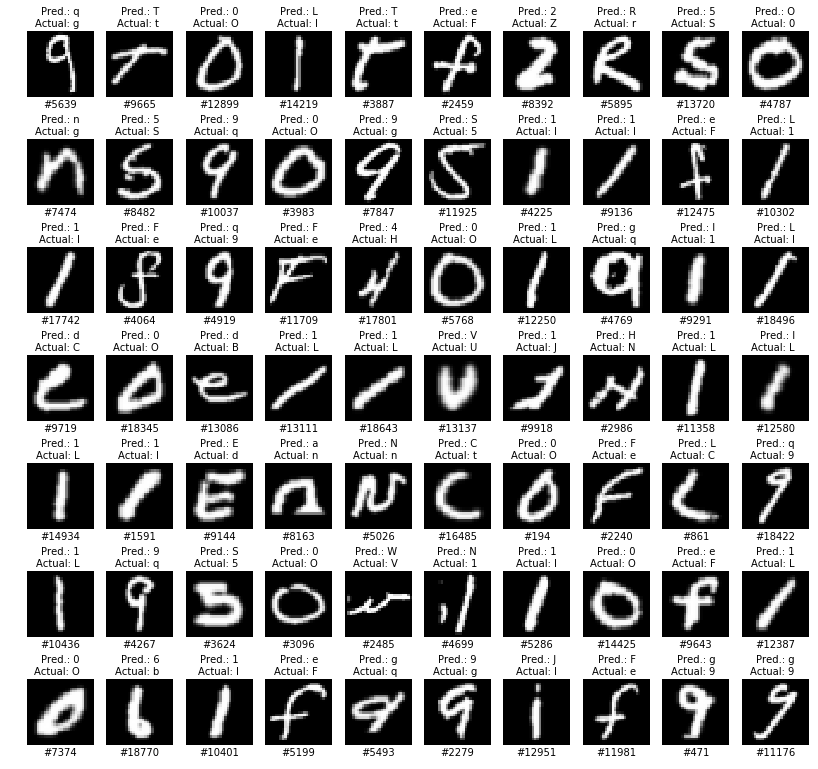

In [170]:
f = plt.figure(figsize=(14,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

for i in range(70): 
    sp = f.add_subplot(7, 10, i+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nActual: {}"
                 .format(lvling47class(preds_incorrect[i]),lvling47class(test_labels[idx_incorrect][i])),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [109]:
# ground truth labels
test_labels[idx_incorrect]

array([41, 46, 24, 18, 46, 15, 35, 45, 28,  0, 41, 28, 44, 24, 41,  5, 18,
       18, 15,  1, 18, 40,  9, 40, 17, 24, 21, 44,  1, 18, 12, 24, 11, 21,
       21, 30, 19, 23, 21, 21, 21, 18, 39, 43, 43, 46, 24, 40, 12,  9, 21,
       44,  5, 24, 31,  1, 18, 24, 15, 21, 24, 37, 18, 15, 44, 41, 18, 40,
        9,  9, 18, 40, 21, 21, 37, 18, 18, 44,  1, 44, 24, 44,  6, 41, 15,
       15, 28, 21, 15, 21, 21, 13, 34,  0, 15,  9, 18,  1, 21,  0, 18, 44,
       39, 44, 24, 46, 30, 17, 18, 18, 12, 41, 21,  6, 24, 41, 44, 15,  2,
       15, 28, 29, 21,  1, 18, 24, 18,  0, 43, 44, 24, 41, 21, 15, 30, 44,
       25,  5, 40, 24, 44, 44,  0, 41,  2, 19, 43, 44, 41, 15, 18, 15, 24,
       18, 33, 24, 21,  1,  4, 34, 46,  0, 36, 21, 41, 21, 36,  1, 24, 21,
        1,  5, 42, 29, 21, 24, 12, 45, 10,  6, 18, 15,  1, 15, 24, 18, 15,
       18, 24,  2, 24, 15, 44, 24,  1, 21, 37, 24, 15, 41, 24, 41, 29, 41,
       40, 46,  8, 24, 19, 41,  1, 15, 18,  9, 40, 34, 15, 46,  8, 40, 21,
       24, 21, 44, 21, 35

In [110]:
idx_incorrect

array([ 5639,  9665, 12899, 14219,  3887,  2459,  8392,  5895, 13720,
        4787,  7474,  8482, 10037,  3983,  7847, 11925,  4225,  9136,
       12475, 10302, 17742,  4064,  4919, 11709, 17801,  5768, 12250,
        4769,  9291, 18496,  9719, 18345, 13086, 13111, 18643, 13137,
        9918,  2986, 11358, 12580, 14934,  1591,  9144,  8163,  5026,
       16485,   194,  2240,   861, 18422, 10436,  4267,  3624,  3096,
        2485,  4699,  5286, 14425,  9643, 12387,  7374, 18770, 10401,
        5199,  5493,  2279, 12951, 11981,   471, 11176, 10923,  8148,
        8096,  7396,  8916, 13680, 12309, 18490,  6991,  4238, 12088,
       11381,   204,  3729,  6858,  9445,  2204,  5859,  9575, 14964,
        6586,  4086, 10164, 10523,  7751, 12861,   223, 17639, 14506,
       16791,  1001,  5856, 18069,  8506,  3188,  4998,  5280,  2763,
       16897, 13225,  5677, 10269,  7719,  7705, 15037,  6047, 11808,
        8743, 16228,  4790, 10672,   370,  7476,  2440, 15821, 17177,
       18327, 10604,

In [111]:
import numpy
numpy.set_printoptions(threshold='nan')

In [1]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

IndentationError: unexpected indent (<ipython-input-1-12668c981d0d>, line 14)

In [113]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[354   0   0   0   0   0   1   0   0   0   0   0   0   4   0   0   2   0
    0   0   0   0   0   0  36   0   1   0   0   0   1   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0   0]
 [  0 299   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   27   0   0  71   0   1   0   0   0   0   0   0   0   0   0   0   1   1
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 362   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   1   0   0   0   0   1   1   0   0   0   0   0   0   0  31
    2   0   1   0   0   0   0   0   0   0   0]
 [  0   0   1 397   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 387   0   0   0   0   0   0   0   0   0   0   0   0   3
    0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   5   0
    1   0   0   0   1   0   0   

Normalized confusion matrix
[[0.89 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
  0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.09 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.07 0.   0.   0.18 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.91 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.08 0.01 0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0

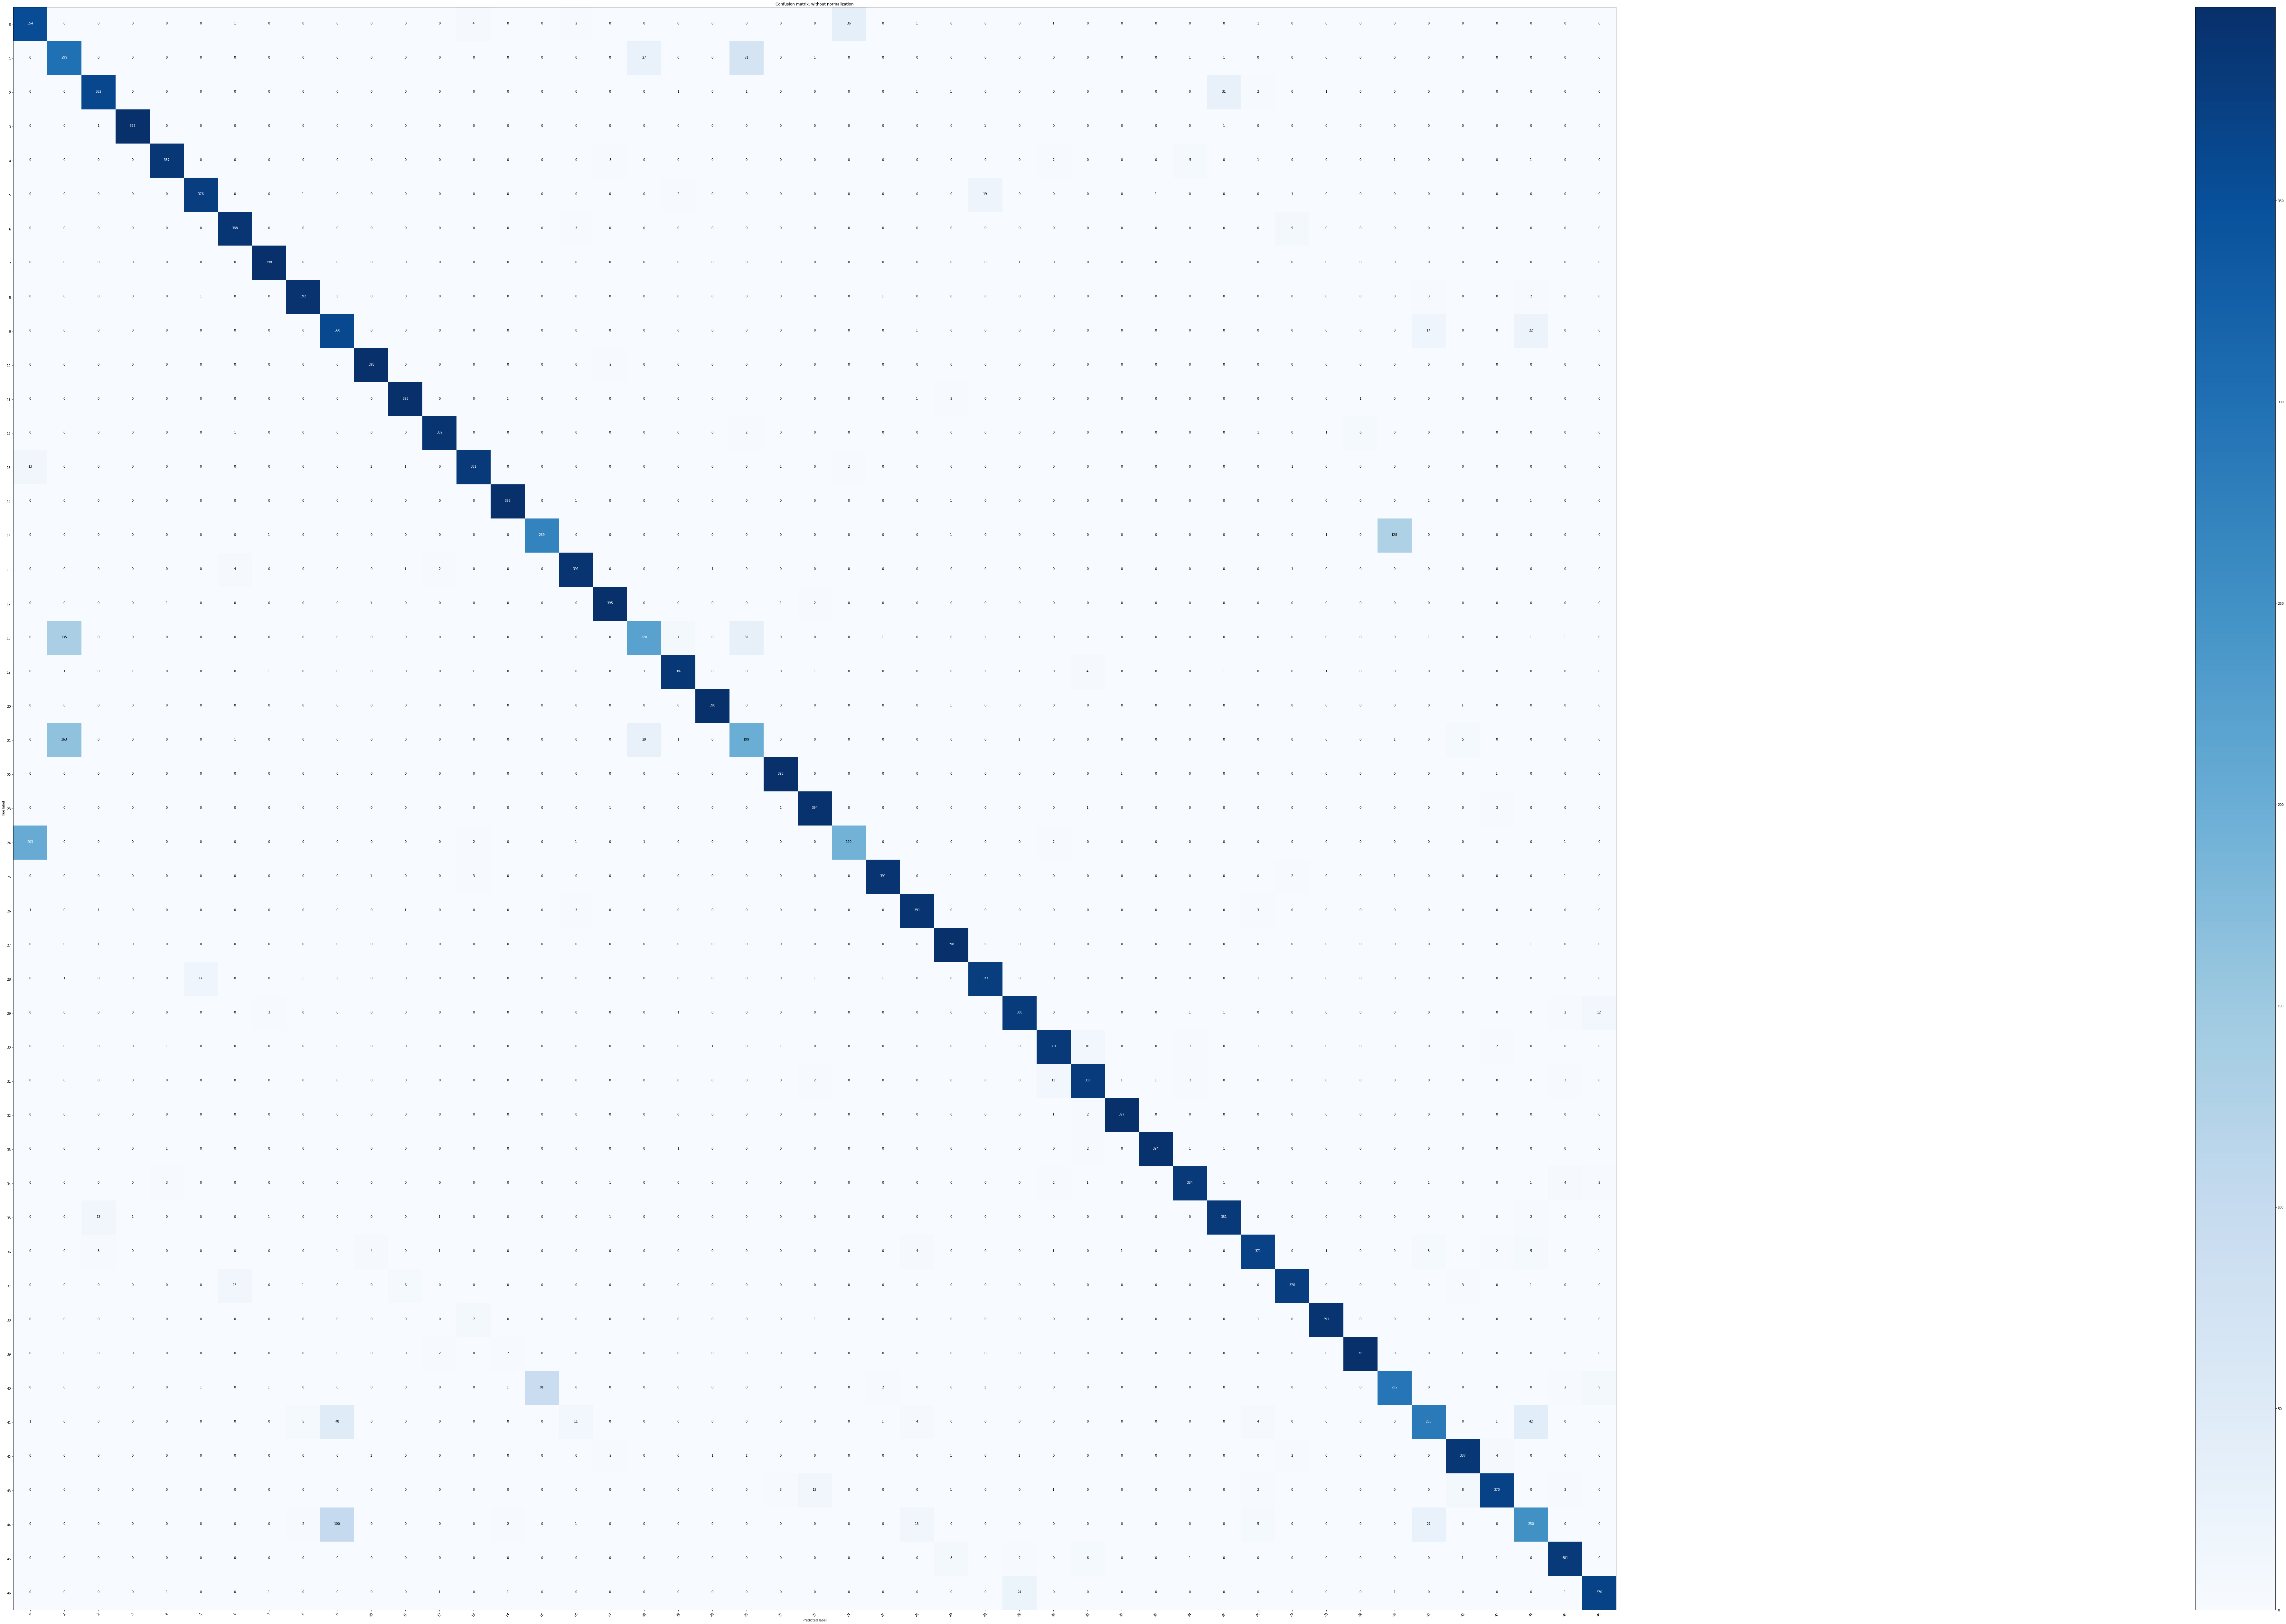

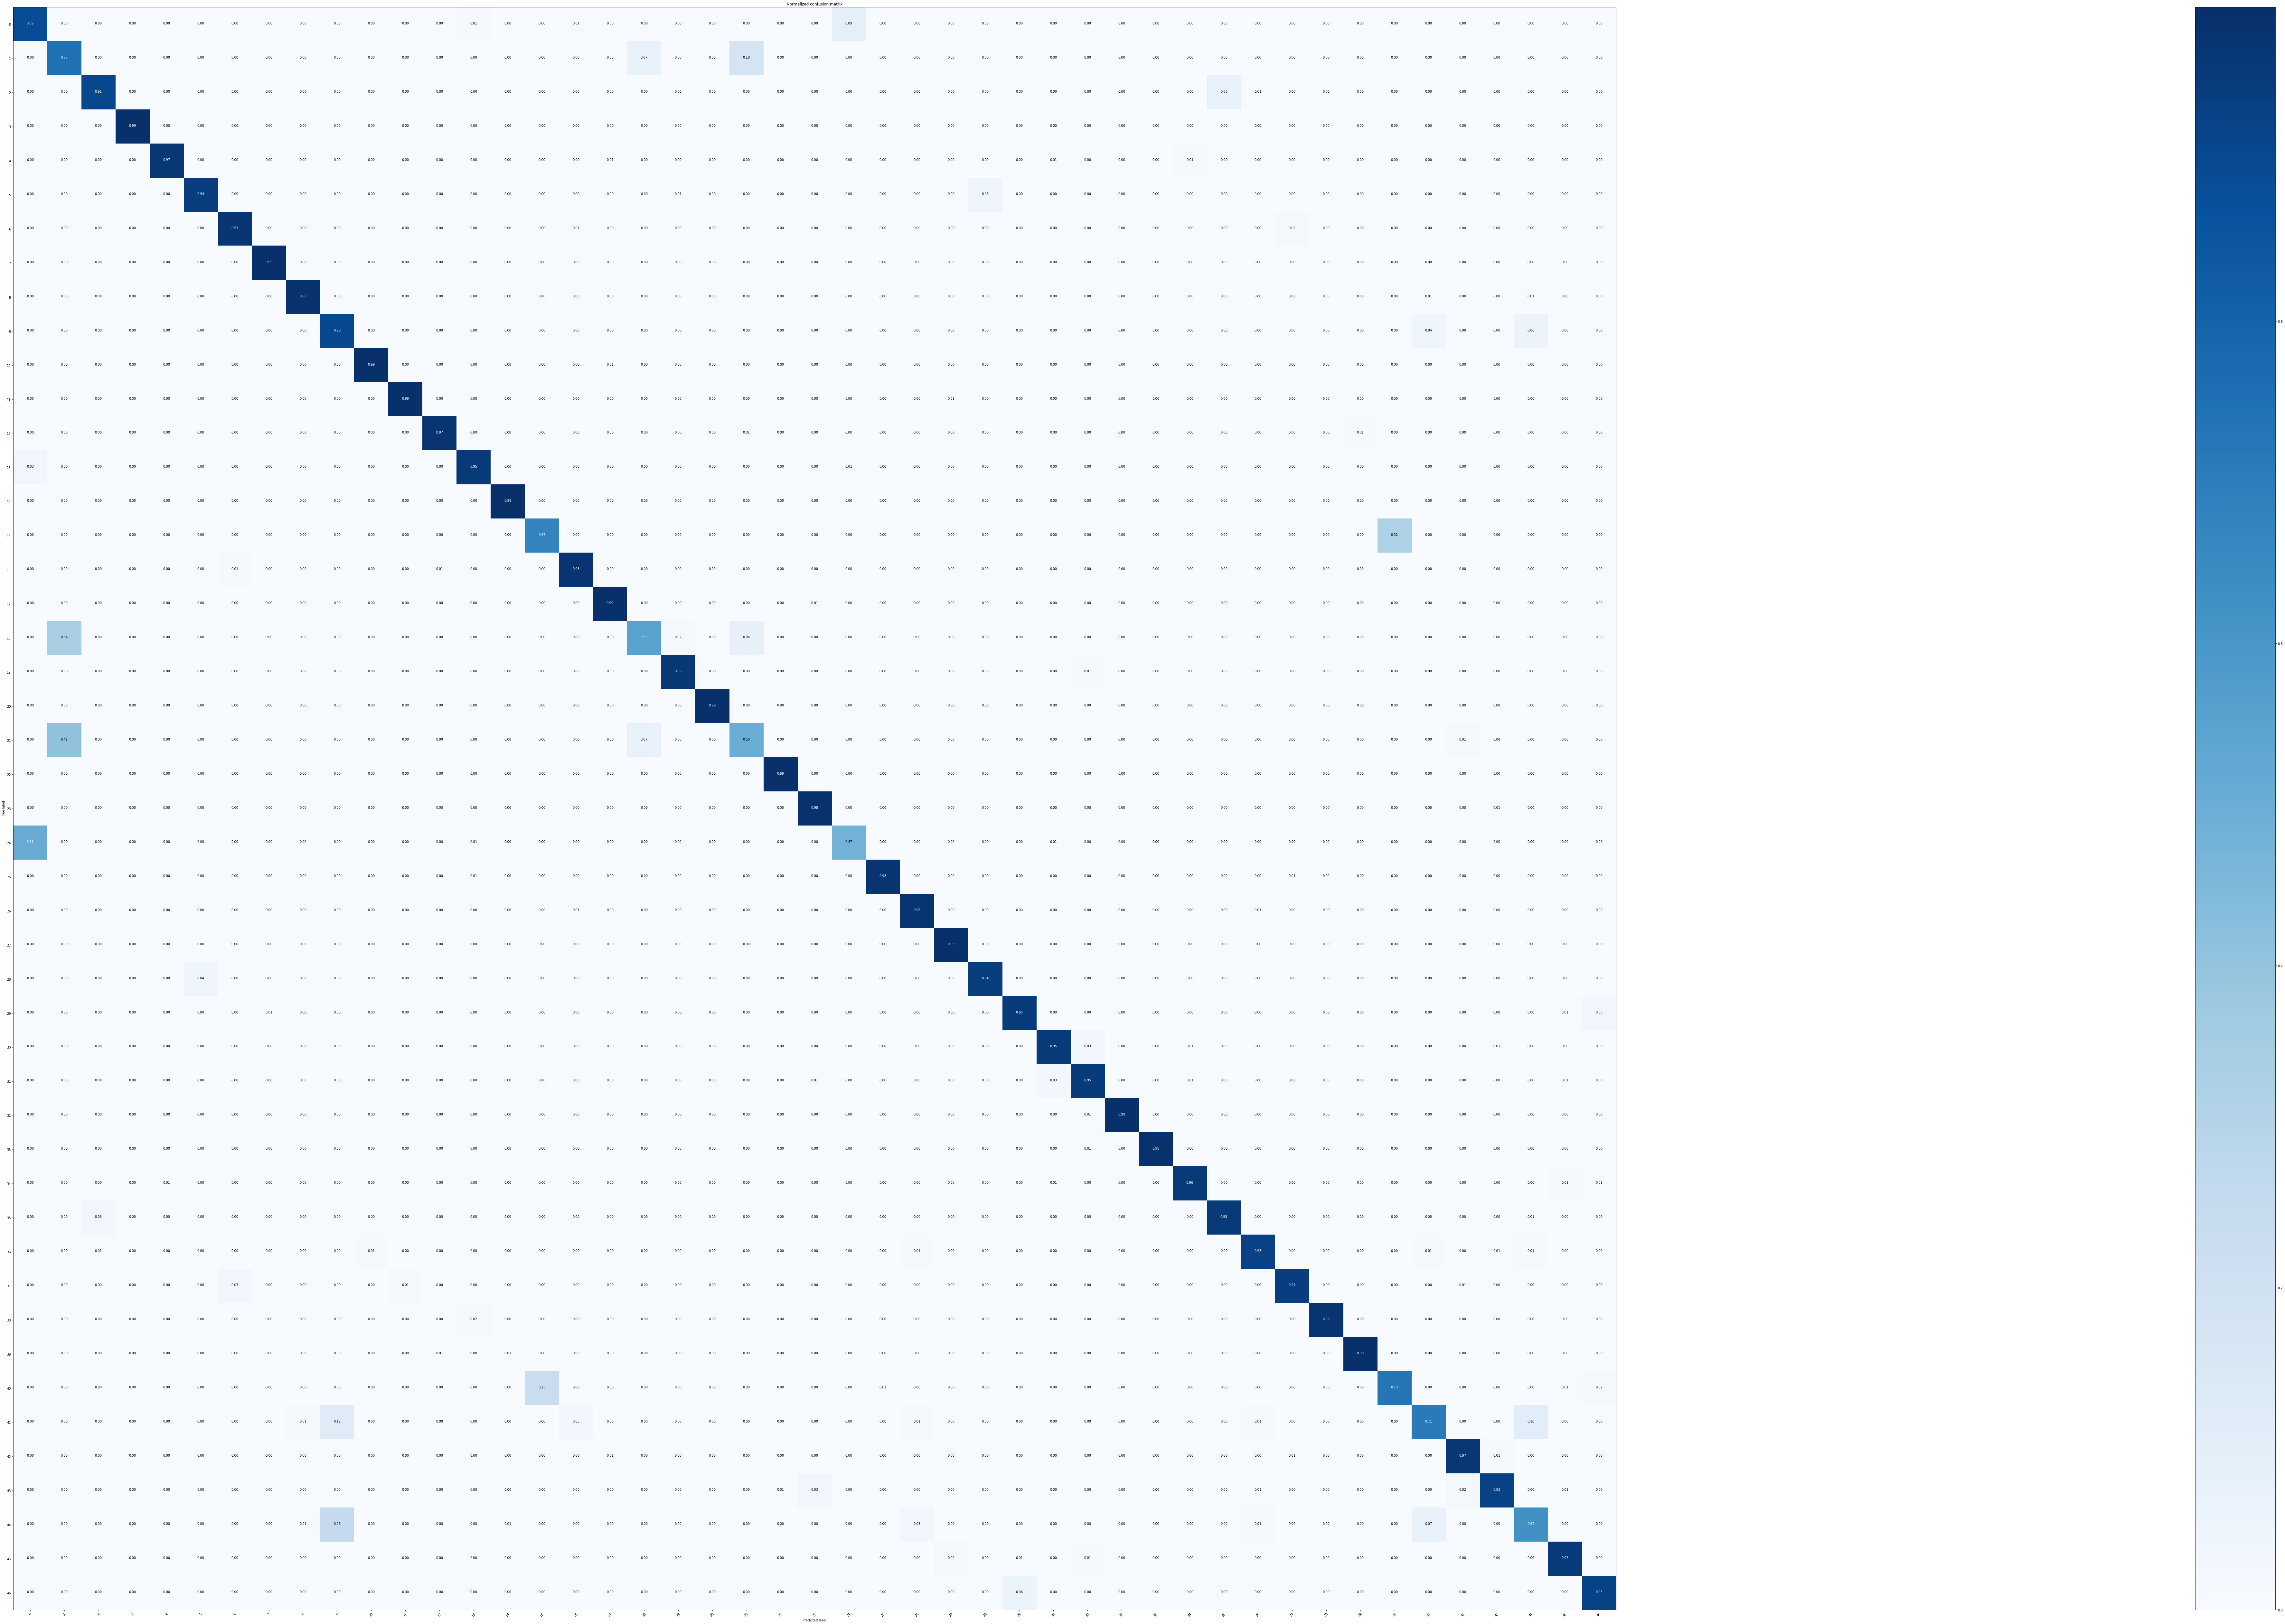

In [114]:
import itertools

class_names = [i for i in range(47)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(500,70))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(500,70))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()